In [26]:
setwd('/import/liujing/data/')

In [27]:
load('./merged.rda')

In [28]:
dim(mtx)

[1] 23241   119

In [29]:
head(mtx,2)

,CI10_M1,CI11_M1,CI12_M1,CI13_M1,CI14_M1,CI15_M1,CI16_M1,CI17_M1,CI18_M1,CI19_M1,...,H18_M2,H1_M2,H2_M2,H3_M2,H4_M2,H5_M2,H6_M2,H7_M2,H8_M2,H9_M2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SEPTIN1,2.51986961,1.67548733,4.18681236,2.26987619,3.24044101,3.55501536,4.0307732,3.77386043,1.53966003,2.75017289,...,4.809603469,2.77330008,3.3104670,3.5195884,3.9592105,3.42288940,4.103651671,6.44042879,4.37327125,4.22811229
MARCHF10,0.01333235,0.07238096,0.06328712,0.02452699,0.05075508,0.05053952,0.1242421,0.07485334,0.01927692,0.02110994,...,0.006029818,0.02833447,0.0357022,0.1064332,0.1270105,0.04040549,-0.006307701,0.07058548,0.03882475,0.01000403


### 差异分析

In [30]:
type = c(rep('CI',43),rep('H',42),rep('CI',16),rep('H',18))

In [31]:
exprSet_by_group <-mtx
group_list <- type

In [32]:
data = exprSet_by_group

In [33]:
group_list = factor(group_list)
design <- model.matrix(~0+group_list)
rownames(design) = colnames(data)
colnames(design) <- levels(group_list)

In [34]:
library(limma)
library(edgeR)

In [35]:
library (dplyr)
df_new <- filter_if(data, is.numeric , all_vars((.) >= 0 ))

In [36]:
dim(df_new)

[1] 15680   119

In [37]:
dim(data)

[1] 23241   119

In [39]:
data = df_new

In [40]:
DGElist <- DGEList( counts = data, group = group_list )
keep_gene <- rowSums( cpm(DGElist) > 5 ) >= 5 # 自定义

keep_gene
FALSE  TRUE 
 2835 12845 

,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
PRR3,0.2915762,4.478103,7.317614,3.034675e-11,2.038649e-07,15.20361
MTND1P11,0.6230576,5.735012,7.308902,3.174230e-11,2.038649e-07,15.16364
RBMS1P1,0.5998660,2.921298,7.092004,9.662015e-11,4.136953e-07,13.99413
MTND5P2,0.5362909,4.885998,6.815606,3.917649e-10,1.258055e-06,12.78045
SMIM12,0.2176614,4.881437,6.759282,5.196670e-10,1.335025e-06,12.51277
LRIF1,0.3404425,5.709420,6.678670,7.773234e-10,1.664120e-06,12.12860


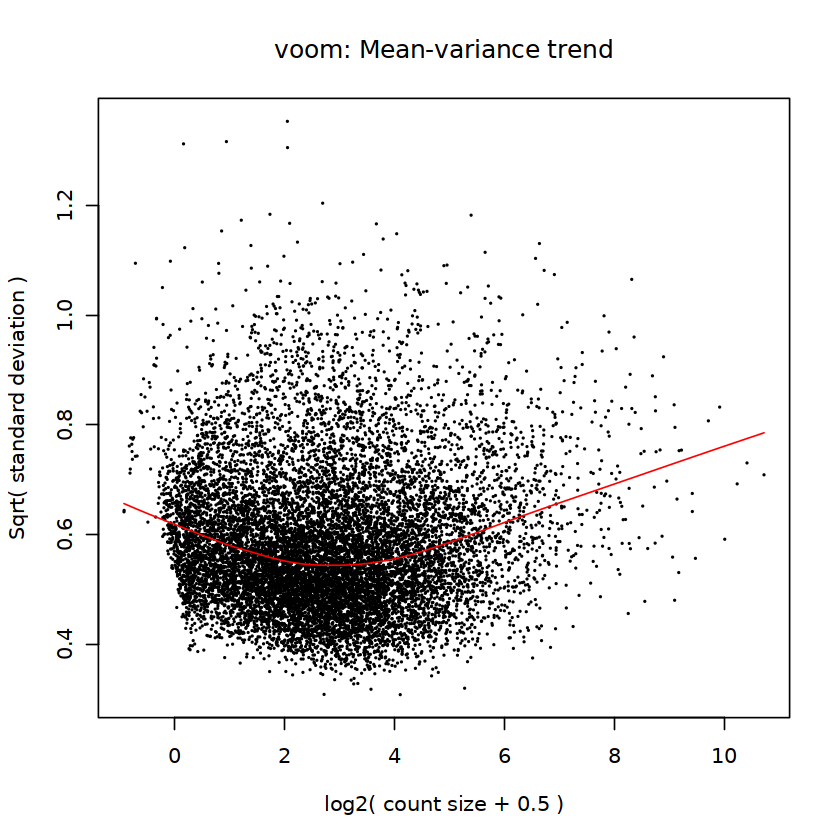

In [41]:

table(keep_gene)
DGElist <- DGElist[ keep_gene, , keep.lib.sizes = FALSE ]

DGElist <- calcNormFactors( DGElist )
v <- voom(DGElist, design, plot = TRUE, normalize = "quantile")
fit <- lmFit(v, design)
cont.matrix <- makeContrasts(contrasts = c('CI-H'), levels = design)

fit2 <- contrasts.fit(fit, cont.matrix)
fit2 <- eBayes(fit2)

nrDEG_limma_voom = topTable(fit2, coef = 'CI-H', n = Inf)
nrDEG_limma_voom = na.omit(nrDEG_limma_voom)
head(nrDEG_limma_voom)

In [137]:
padj = 0.01 # 自定义
foldChange= 0 # 自定义
nrDEG_limma_voom_signif = nrDEG_limma_voom[(nrDEG_limma_voom$P.Value < padj & 
                          (nrDEG_limma_voom$logFC>foldChange | nrDEG_limma_voom$logFC<(-foldChange))),]
nrDEG_limma_voom_signif = nrDEG_limma_voom_signif[order(nrDEG_limma_voom_signif$logFC),]

In [138]:
dim(nrDEG_limma_voom_signif)

[1] 3177    6

In [149]:
a = nrDEG_limma_voom_signif[!grepl("^MIR", rownames(nrDEG_limma_voom_signif)),]

In [150]:
a = a[!grepl("^SNO", rownames(a)),]

In [151]:
a = a[!grepl("^IGH", rownames(a)),]

In [152]:
write.csv(a,file = 'nrDEG_limma_voom_signif.csv')

In [153]:
load('/import/liujing/data/scRNA/genename.rda')

b = intersect(rownames(a),geneame)

In [154]:
expr2 = mtx[b,]

In [155]:
expr = expr2 %>% t() %>%  as.data.frame()

In [156]:
save(expr,Type,file = 'expr2.merged.rda')